## Advanced Lane Finding Notebook ##
This project calibrates images from a vehicles central camera for use in detecting lanes.

In [1]:
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

### Testing Images ###
Load the images used to prove out the lane finding pipeline

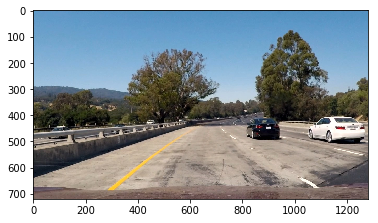

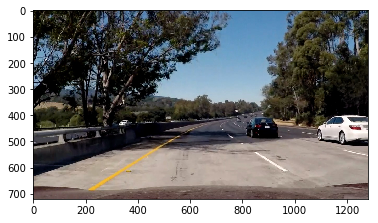

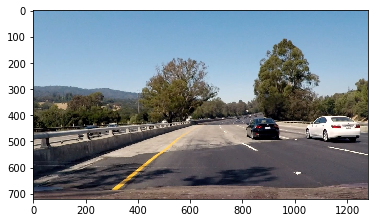

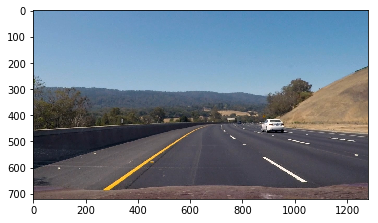

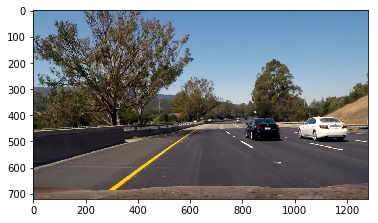

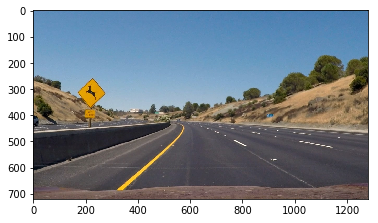

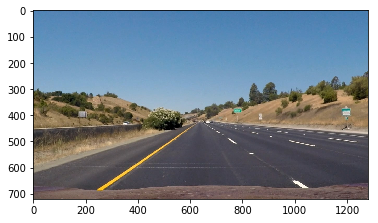

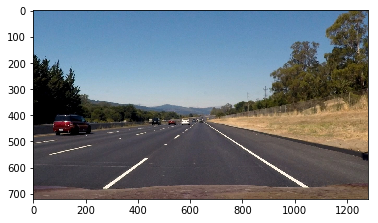

In [19]:
def getTestingImages(pathname):
    files = glob.glob(pathname)
    images = []
    for fname in files:
        img = mpimg.imread(fname)
        plt.imshow(img)
        plt.show()
        images.append(img)
    return images

testImages = getTestingImages('test_images/test*.jpg')  
testImages = testImages + getTestingImages('test_images/straight_lines*.jpg')

_Functions for displaying images_

In [56]:
def plotOne(img1, title1, cmap1=None):
    plt.imshow(img1, cmap=cmap1)
    plt.title(title1)
    plt.show()
    return

def plotMany(nrows, ncols, images, titles, cmaps):
    f, axes = plt.subplots(nrows, ncols, figsize=(16, 6))
    if nrows == 1 or ncols == 1:
        for idx, img in enumerate(images):
            axes[idx].imshow(img, cmap=cmaps[idx])
            axes[idx].set_title(titles[idx]) 
    else:
        c = 0
        for idx, img in enumerate(images):
            r = idx//ncols
            axes[r,c].imshow(img, cmap=cmaps[idx])
            axes[r,c].set_title(titles[idx])
            c = (idx + 1) % ncols        
    plt.tight_layout()
    plt.show()
    return

def plotTwo(img1, img2, title1, title2, cmap1=None, cmap2=None):
    plotMany(1, 2, [img1,img2], [title1,title2], [cmap1,cmap2])
    return

### Camera Calibration ###
Prior to executing the lane finding pipeline, the camera must be calibrated using 9x6 chessboard images.  This is only completed once.

_Globals and Functions for calibration:_

In [3]:
nx = 9
ny = 6

worldPoints = []
worldPt = np.zeros((nx*ny,3), np.float32)
worldPt[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) 

imagePoints = []

def findChessboardPoints(fname):
    # Find the chessboard corners of file.
    iRGB = mpimg.imread(fname)
    
    # Search for the image chessboard points
    gray = cv2.cvtColor(iRGB, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # Store the points if found
    if ret == True:
        worldPoints.append(worldPt)
        imagePoints.append(corners)
        iRGB = cv2.drawChessboardCorners(iRGB, (nx,ny), corners, ret)
    return iRGB

_Testing/Plotting Cell:_

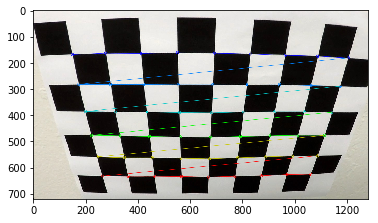

In [4]:
iRGB = findChessboardPoints('camera_cal/calibration2.jpg')
plt.imshow(iRGB)

Process all the provided calibration images and run the calibration.

In [5]:
images = glob.glob('camera_cal/calibration*.jpg')
for chessboard in images:
    findChessboardPoints(chessboard)

print("Calibration points found in {} of {} images".
      format(len(imagePoints), len(images)))

ret, cameraMtx, distCoeffs, rotVecs, transVecs = cv2.calibrateCamera(
    worldPoints, imagePoints, iRGB.shape[0:2], None, None)

Calibration points found in 18 of 20 images


### Lane Finding Pipeline ###
1. Distortion correction
2. Binary image threshold creation
3. Perspective transformation
4. Lane line identification
5. Curvature and location estimation

#### Distortion Correction ####
_Functions for undistortion:_

In [6]:
def undistortImage(img):
    # Undistort the image by refining the camera matrix,
    # running the function, then cropping to the region of interest
    h,w = img.shape[:2]
    newMtx, roi = cv2.getOptimalNewCameraMatrix(cameraMtx, distCoeffs,
                                                (w,h), 1, (w,h))
    undist = cv2.undistort(img, cameraMtx, distCoeffs, None, newMtx)
    x,y,w,h = roi
    return undist[y:y+h, x:x+w]

_Testing/Plotting Cell:_

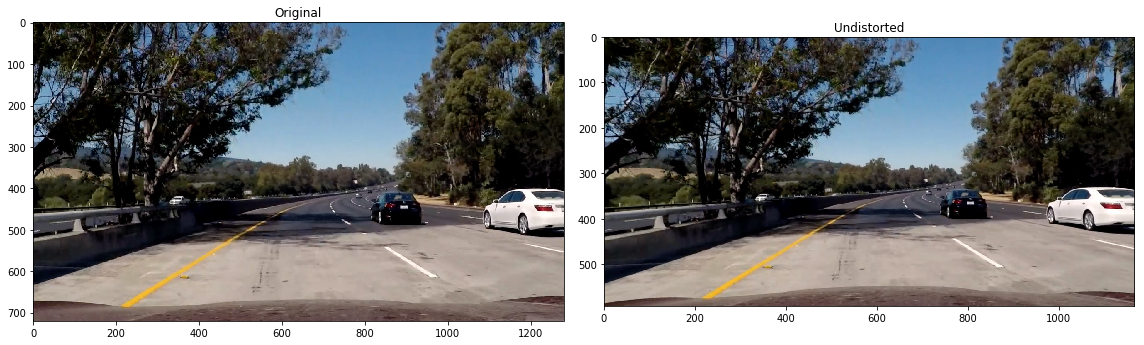

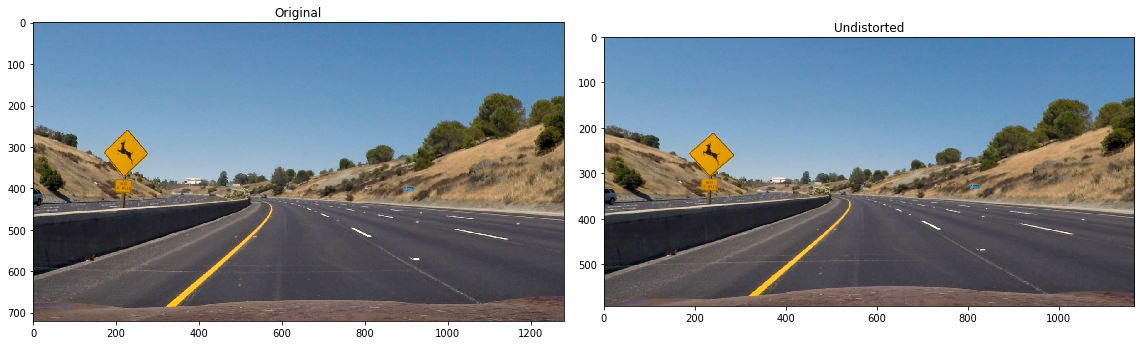

In [58]:
testUndistorteds = []
for img in testImages:
    testUndistorteds.append(undistortImage(img))

samples = random.sample(testImages, 2)
plotTwo(samples[0], undistortImage(samples[0]),
        'Original', 'Undistorted')
plotTwo(samples[1], undistortImage(samples[1]),
        'Original', 'Undistorted')

#### Binary Image Threshold Creation ####
_Functions to create filtered binary images:_  

In [62]:
def applyThreshold(binary, thresh=(0, 255)):
    # Apply the threshold
    binary_th = np.zeros_like(binary)
    binary_th[(binary >= thresh[0]) & (binary <= thresh[1])] = 1
    return binary_th

def applyThresholdSobelAbs(img, orient='x', 
                           sobel_kernel=15, 
                           thresh=(50,100)):
    # Calculate the directional gradient
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return applyThreshold(scaled_sobel, thresh)

def applyThresholdSobelMag(img, sobel_kernel=15, thresh=(50,100)):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    return applyThreshold(scaled_sobel, thresh)

def applyThresholdSobelDir(img, sobel_kernel=15, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.sqrt(np.square(sobelx))
    abs_sobely = np.sqrt(np.square(sobely))
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)
    return applyThreshold(dir_sobel, thresh)

def applyThresholdSaturation(img, thresh=(0, 255)):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    return applyThreshold(s_channel, thresh)

def applyAllThresholds(img):
    kSize = 15 #Larger odd number to smooth gradient measurements
    thresh = (50,100)
    gradx = applyThresholdSobelAbs(img, 'x', kSize, thresh)
    grady = applyThresholdSobelAbs(img, 'y', kSize, thresh)
    magBinary = applyThresholdSobelMag(img, kSize, thresh)
    dirBinary = applyThresholdSobelDir(img, kSize, (0.7, 1.3))
    satBinary = applyThresholdSaturation(img, (170, 255))
    return gradx, grady, magBinary, dirBinary, satBinary 

_Testing/Plotting Cell:_

In [11]:
def plotCombinedBinaries(sobel_binary, color_binary, combined_binary):
    # Stack each channel to view contributions
    stacked_binary = np.dstack((np.zeros_like(sobel_binary), 
                                sobel_binary, 
                                color_binary))
    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(stacked_binary)

    ax2.set_title('Combined color channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')
    plt.show()

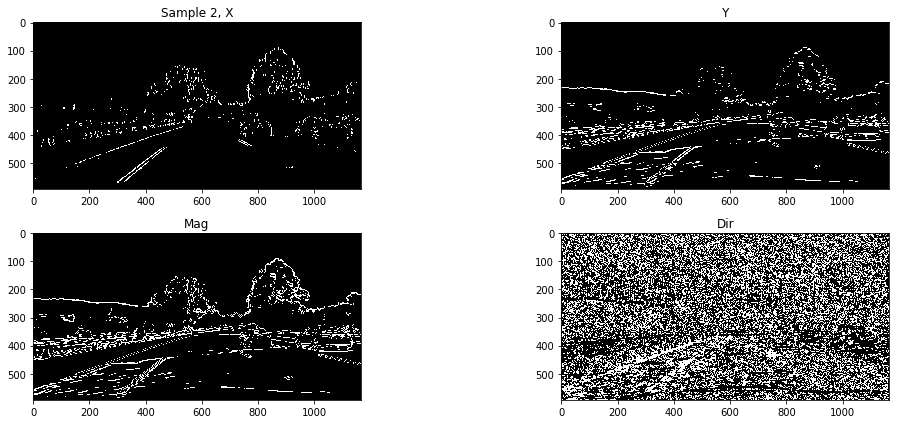

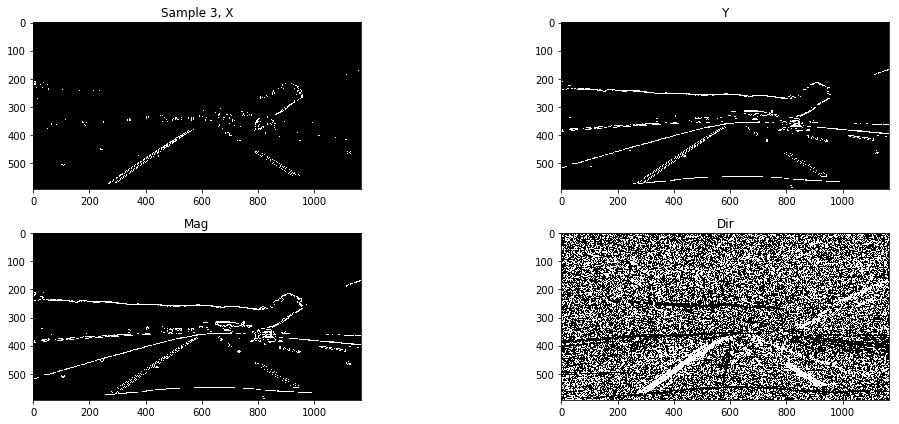

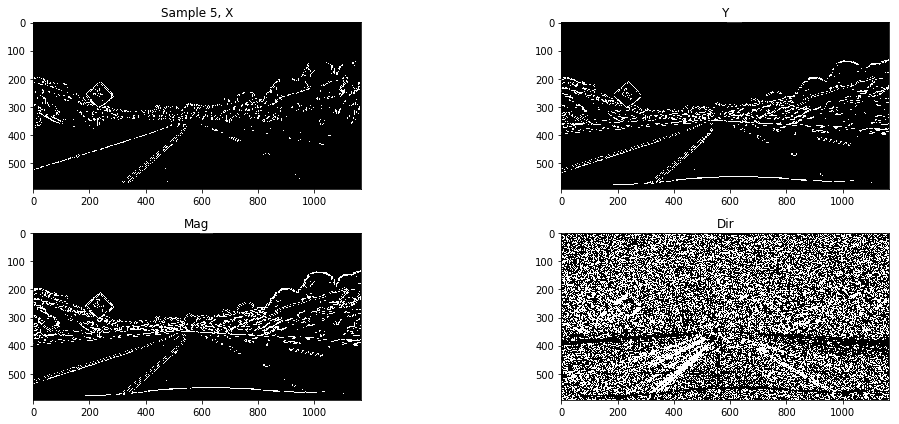

In [69]:
samples = random.sample(range(0,len(testUndistorteds)), 3)
grayMaps = ['gray','gray','gray','gray']

for idx, img in enumerate(testUndistorteds):
    # Run all the threshold calculations
    gradxB, gradyB, magB, dirB, satB = applyAllThresholds(img)
    
    if idx in samples:
        plotMany(2, 2, [gradxB, gradyB, magB, dirB],
                ["Sample {}, X".format(idx),'Y','Mag','Dir'],
                 grayMaps)

In [ ]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | 
         ((mag_binary == 1) & (dir_binary == 1))] = 1
combined[((mag_binary == 1) & (dir_binary == 1))] = 1
combined[((gradx == 1) & (dir_binary == 1))] = 1



plot_sobel_binary(image, combined, 'X & Y thresh | mag & dir')
plot_sobel_binary(image, combined, 'mag & dir')
plot_sobel_binary(image, combined, 'X thresh & dir')

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
plot_combined_binaries(sxbinary, s_binary, combined_binary)

# Combine two gradients then the color threshold
grad_combined = np.zeros_like(sxbinary)
grad_combined[((sxbinary == 1) & (dirbinary == 1))] = 1
combined_binary2 = np.zeros_like(sxbinary)
combined_binary2[(s_binary == 1) | (grad_combined == 1)] = 1
plot_combined_binaries(grad_combined, s_binary, combined_binary2)

#### Perspective Transformation ####

#### Lane Line Identification ####

#### Curvature and Location Estimation ####